In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats

In [2]:
spread_odds = pd.read_csv("nba_betting_spread.csv")
games = pd.read_csv("nba_games_all.csv")

In [3]:
def updated_portfolio_generator(year):
    # try more advanced game prediction - use points allowed
    opp_games = pd.read_csv("nba_games_all.csv")
    opp_games = opp_games.sort_values(by="game_id")
    opp_games = opp_games.sort_values(by="game_date")
    opp_games = opp_games[opp_games["season_year"]==year]
    opp_games = opp_games[opp_games["season_type"]=="Regular Season"]
    
    games = pd.read_csv("nba_games_all.csv")
    games = games.sort_values(by="game_id")
    games = games.sort_values(by="game_date")
    games = games[games["season_year"]==year]
    games = games[games["season_type"]=="Regular Season"]
    
    spread_odds = pd.read_csv("nba_betting_spread.csv")
    
    team_ids = list(set(opp_games["team_id"]))
    
    # how many points does each team score per game
    team_dict = {}
    for team_id in team_ids:
        team_df = games[games["team_id"]==team_id]
        team_df = team_df.sort_values(by="game_date")
        points = team_df["pts"]
        points = points[:50]
        mean = np.mean(points)
        std = np.std(points)
        team_dict[team_id] = [mean,std]
    
    # how many points does each team allow per game
    points_allowed_dict = {}
    for team_id in team_ids:
        a_team_points_list = []
        # find all the games where they're the a_team
        for game_id in sorted(list(set(opp_games["game_id"]))):
            test = opp_games[opp_games["game_id"]==game_id]
            #print(test)
            test = test[test["a_team_id"] == team_id]
            if test.empty == False:
                a_team_points_list.append(int(np.mean(test["pts"])))
        mean = np.mean(a_team_points_list[:50])
        std = np.std(a_team_points_list[:50])

        points_allowed_dict[team_id] = [mean, std]

    # get spreads for each game
    game_ids = list(set(games["game_id"]))
    spread_odds = spread_odds[spread_odds["book_name"]=="Pinnacle Sports"]

    spreads = {}
    for game_id in game_ids:
        spread = spread_odds[spread_odds["game_id"]==game_id]
        spreads[game_id] = np.mean(spread["spread1"])

    game_ids = sorted(game_ids)
    probability_dict = {}
    for game_id in game_ids[750:]:
        # determine a p value for the spread based on differences
        # first pull the teams - use the one with @ because home team is clear
        desired_game = games[games["game_id"] == game_id]
        desired_game = desired_game.loc[desired_game['matchup'].str.contains("@")]

        # retrieve mean and std for games
        home_team = int(np.mean(desired_game.team_id))
        away_team = int(np.mean(desired_game.a_team_id))

        home_team_ppg = team_dict[home_team][0]
        home_team_std = team_dict[home_team][1]
        away_team_allowed_ppg = points_allowed_dict[away_team][0]
        ppg = np.mean([home_team_ppg, away_team_allowed_ppg])


        away_team_ppg = team_dict[away_team][0]
        away_team_std = team_dict[away_team][1]
        home_team_allowed_ppg = points_allowed_dict[home_team][0]
        appg = np.mean([away_team_ppg, home_team_allowed_ppg])

        diff_mean = ppg - appg
        diff_std = np.sqrt(home_team_std**2 + away_team_std**2)

        probability_dict[game_id]=scipy.stats.norm(diff_mean, diff_std).cdf(spreads[game_id])

    over_list = []
    under_list = []
    for game_id in probability_dict:
        if probability_dict[game_id] > 0.70:
            under_list.append(game_id)
        elif probability_dict[game_id] < 0.30:
            over_list.append(game_id)

    backtest_games = pd.read_csv("nba_games_all.csv")
    #backtest_games = backtest_games[backtest_games["season_year"]==year]
    portfolio = []
    portfolio.append(100)
    for game_id in game_ids:
        if game_id in over_list:
            spread = spreads[game_id]
            outcomes = backtest_games[backtest_games["game_id"]==game_id]
            #outcomes = outcomes.loc[outcomes['matchup'].str.contains("@")]
            home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
            away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
            if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                continue
            actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))

            if actual_spread > spread:
                portfolio.append(portfolio[len(portfolio)-1]+1)
            else:
                portfolio.append(portfolio[len(portfolio)-1]-1)

        if game_id in under_list:
            spread = spreads[game_id]
            outcomes = backtest_games[backtest_games["game_id"]==game_id]
            #outcomes = outcomes.loc[outcomes['matchup'].str.contains("@")]

            home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
            away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
            if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                continue
            actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))
            if actual_spread < spread:
                portfolio.append(portfolio[len(portfolio)-1]+1)
            else:
                portfolio.append(portfolio[len(portfolio)-1]-1)
    print(portfolio)
    plt.scatter(range(len(portfolio)),portfolio)


[100, 101, 102, 101, 102, 103, 102, 101, 102, 101, 102, 103, 104, 103, 102, 103, 104, 103, 102, 101, 102, 103, 102, 101, 102, 103, 102, 103, 102, 103, 104, 105, 106, 105, 106, 107, 108, 109, 108, 109, 110, 111, 110, 109, 110, 109, 108, 107, 106, 107, 108, 107, 108, 107, 106, 105]


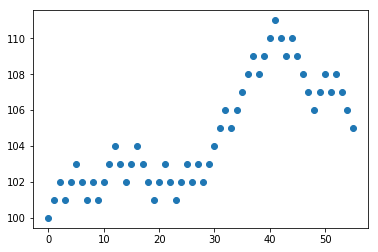

In [4]:
updated_portfolio_generator(2015)

[100, 101, 100, 99, 98, 99, 100, 101, 100, 99, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 91, 90, 89, 90, 91, 92, 91, 92, 91, 90, 91, 92, 93, 92, 93, 94, 93, 94, 93, 94, 93, 92, 91, 92, 91, 90, 89]


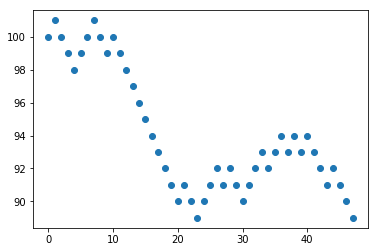

In [5]:
updated_portfolio_generator(2016)

In [ ]:
updated_portfolio_generator(2017)

In [90]:
# new strategy - generate average per game id and then bet on that game
def new_strategy(year):
    games = pd.read_csv("nba_games_all.csv")
    games = games.sort_values(by="game_id")
    games = games.sort_values(by="game_date")
    games = games[games["season_year"]==year]
    games = games[games["season_type"]=="Regular Season"]

    spread_odds = pd.read_csv("nba_betting_spread.csv")
    spread_odds = spread_odds[spread_odds["book_name"]=="Pinnacle Sports"]

    game_ids = sorted(list(set(games["game_id"])))

    probability_dict = {}
    over_list = []
    under_list = []
    for game_id in game_ids[750:]:

        # find total number of games played by each team by adding record
        desired_game = games[games["game_id"]==game_id]

        #print(desired_game) #47 is LAL

        home_game = desired_game.loc[desired_game['matchup'].str.contains("@")]
        away_game = desired_game = desired_game.loc[desired_game['matchup'].str.contains("vs")]
        home_team_games_played = int(home_game['w'] + home_game['l'])
        away_team_games_played = int(away_game['w'] + away_game['l'])
        #print(home_team_games_played)
        #print(away_team_games_played)

        # then find moving average and variance number of points scored by each team
        home_team_id = int(np.mean(home_game['team_id']))
        away_team_id = int(np.mean(away_game['team_id']))
        #print(home_team_id)
        #print(away_team_id)

        home_team_df = games[games["team_id"]==home_team_id].sort_values(by="game_id")
        away_team_df = games[games["team_id"]==away_team_id].sort_values(by="game_id")

        home_points = home_team_df['pts'][:home_team_games_played]
        away_points = away_team_df['pts'][:away_team_games_played]

        home_points_mean = np.mean(home_points)
        away_points_mean = np.mean(away_points)
        home_points_std = np.std(home_points)
        away_points_std = np.std(away_points)

        # then find moving average of number of points allowed by each team
        home_team_points_allowed_df = games[games["a_team_id"]==home_team_id].sort_values(by="game_id")
        home_team_mean_points_allowed = np.mean(home_team_points_allowed_df['pts'][:home_team_games_played])

        away_team_points_allowed_df = games[games["a_team_id"]==away_team_id].sort_values(by="game_id")
        away_team_mean_points_allowed = np.mean(away_team_points_allowed_df['pts'][:away_team_games_played])

        # pull the spread for that game
        spread = float(np.mean(spread_odds[spread_odds["game_id"] == game_id]["spread1"])) # amount home team should win by
        #print(spread)

        # calculate p value for that spread based on expected number of points scored and variance
        home_points_scored = np.mean([home_points_mean, away_team_mean_points_allowed])
        away_points_scored = np.mean([away_points_mean, home_team_mean_points_allowed])
        expected_spread = home_points_scored - away_points_scored
        spread_std = np.sqrt(home_points_std**2 + away_points_std**2)

        probability = scipy.stats.norm(expected_spread, spread_std).cdf(spread)
        if probability > 0.65:
            under_list.append(game_id)
        elif probability < 0.35:
            over_list.append(game_id)

        #probability_dict[game_id]=scipy.stats.norm(expected_spread, spread_std).cdf(spread)
        #print(expected_spread)
    portfolio = []
    portfolio.append(100)
    for game_id in game_ids:
        if game_id in over_list:
            spread = float(spread_odds[spread_odds["game_id"]==game_id]["spread1"])
            outcomes = games[games["game_id"]==game_id]
            home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
            away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
            if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                continue
            actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))

            if actual_spread > spread:
                portfolio.append(portfolio[len(portfolio)-1]+1)
            else:
                portfolio.append(portfolio[len(portfolio)-1]-1)

        if game_id in under_list:
            spread = float(spread_odds[spread_odds["game_id"]==game_id]["spread1"])
            outcomes = games[games["game_id"]==game_id]
            #outcomes = outcomes.loc[outcomes['matchup'].str.contains("@")]

            home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
            away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
            if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                continue
            actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))
            if actual_spread < spread:
                portfolio.append(portfolio[len(portfolio)-1]+1)
            else:
                portfolio.append(portfolio[len(portfolio)-1]-1)
    print(portfolio)
    plt.plot(range(len(portfolio)),portfolio)




[100, 101, 102, 103, 102, 103, 102, 103, 104, 103, 102, 101, 102, 103, 102, 101, 100, 101, 102, 103, 102, 103, 104, 103, 102, 103, 104, 103, 104, 103, 102, 103, 102, 101, 100, 101, 102, 101, 102, 103, 102, 103, 104, 103, 104, 103, 102, 103, 102, 103, 104, 105, 106, 105, 106, 107, 106, 105, 106, 105, 106, 105, 104, 103, 104, 103, 102, 103, 102, 101, 102, 103, 102, 101, 100, 101, 100, 101, 102, 103, 104, 103, 102, 103, 104, 105, 104, 105, 106, 107, 106, 107, 106, 105, 104, 105, 104, 103, 102, 103, 104, 105, 104]


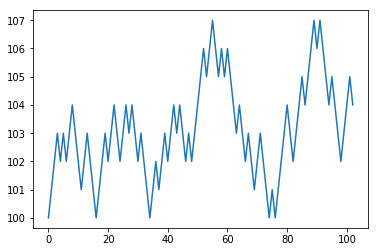

In [91]:
new_strategy(2017)

[100, 101, 100, 101, 100, 101, 102, 101, 102, 101, 100, 99, 100, 101, 102, 103, 102, 101, 102, 101, 102, 103, 104, 103, 104, 103, 102, 103, 104, 105, 104, 103, 104, 105, 106, 107, 106, 107, 106, 105, 106, 107, 108, 107, 108, 107, 108, 107, 106, 105, 104, 103, 102, 103, 102, 101, 102, 101, 100, 101, 102, 103, 102, 101, 102, 101, 102, 103, 104, 103, 102, 101, 102, 103, 104, 103, 104, 105, 106, 105, 106, 105, 106, 107, 108, 109, 108, 109, 110, 109, 110, 111, 110, 109, 110, 109, 110, 109, 110, 109, 108]


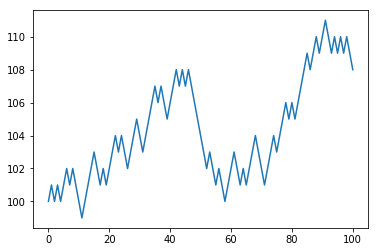

In [92]:
new_strategy(2016)

[100, 101, 100, 99, 100, 101, 100, 101, 102, 103, 102, 103, 104, 105, 104, 105, 106, 107, 108, 109, 110, 109, 108, 109, 110, 109, 108, 109, 110, 111, 112, 113, 114, 115, 114, 113, 114, 113, 114, 113, 114, 115, 114, 115, 116, 115, 116, 115, 114, 115, 116, 115, 116, 117, 118, 117, 118, 119, 120, 119, 118, 119, 118, 119, 118, 119, 118, 119, 118, 119, 120, 121, 120, 119, 120, 121, 120, 121, 122, 123, 122, 123, 124, 125, 126, 127, 128, 127, 126, 127, 128, 127, 126, 125, 126, 127, 128, 127, 126, 125, 126, 125, 126, 127, 128, 127, 126, 125, 126, 125, 126, 127, 126, 127, 128, 129, 128, 129, 128, 127, 126, 127]


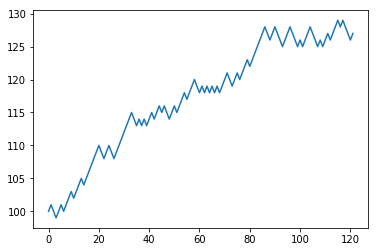

In [93]:
new_strategy(2015)

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


[100, 99, 98, 97, 96, 97, 96, 97, 98, 97, 96, 95, 96, 97, 96, 97, 96, 95, 96, 95, 94, 93, 94, 95, 94, 93, 94, 93, 94, 93, 94, 95, 96, 95, 96, 95, 96, 97, 96, 97, 96, 97, 96, 95, 94, 95, 96, 97, 98, 99, 98, 97, 98, 97, 98, 97, 96, 95, 96, 97, 98, 99, 98, 99, 100, 99, 100, 101, 100, 99, 98, 99, 100, 101, 102, 101, 102, 101, 102, 101, 102, 103, 104, 105, 104, 103, 102, 103, 102, 101, 100, 101, 100, 99, 98, 99, 100, 101, 102, 103, 102, 103, 104, 105, 104, 103, 104, 105, 106, 107, 106, 105, 104, 103, 102, 101, 102, 101, 102, 103, 104, 105, 106, 107, 108, 107, 106, 105, 104, 105, 106, 107, 108, 107, 106, 107, 108, 107, 106, 105, 104, 103, 102, 103]


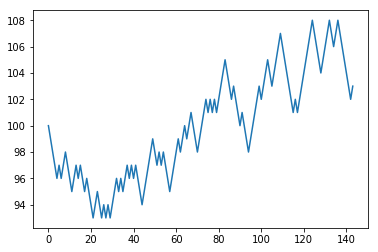

In [94]:
new_strategy(2014)

[100, 99, 98, 99, 98, 99, 100, 101, 102, 103, 104, 103, 102, 103, 104, 105, 104, 105, 104, 105, 104, 105, 104, 103, 102, 101, 100, 101, 100, 99, 98, 99, 98, 97, 98, 99, 98, 99, 100, 101, 102, 103, 104, 105, 104, 103, 102, 103, 104, 103, 102, 101, 102, 103, 102, 103, 102, 103, 104, 103, 104, 105, 106, 105, 104, 103, 104, 103, 104, 105, 104, 105, 106, 107, 106, 105, 104, 105, 106, 105, 106, 105, 104, 103, 104, 103, 102, 103, 102, 101, 102, 103, 102, 103, 102, 103, 102, 103, 102, 103, 102, 103, 104, 103, 104, 103, 104, 105, 106, 107, 106, 105, 106, 107, 108, 109, 110, 109, 108, 107, 106, 107, 108, 109, 110, 109, 110, 109, 110, 111]


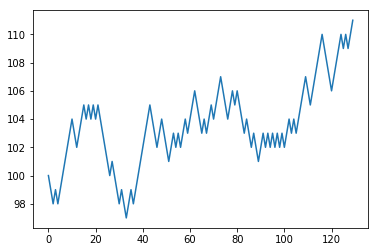

In [62]:
new_strategy(2013)

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

[100, 99, 98, 99, 100, 101, 102, 101, 102, 101, 102, 103, 102, 101, 100, 99, 100, 99, 100, 99, 100, 101, 102, 103, 102, 103, 104, 103, 104, 105, 106, 105, 106, 105, 104, 103, 102, 103, 102, 103, 104, 103, 102, 103, 102, 103, 102, 103, 104, 103, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 95, 96, 95, 94, 95, 96, 97, 96, 95, 96, 95, 96, 95, 96, 97, 96, 97, 98, 97, 98, 99, 100, 101, 102, 101, 102, 103, 104, 103, 102, 101, 102, 101, 100, 101, 102, 103, 102, 103, 104, 103, 104, 103, 104, 103, 102, 103, 104, 105, 106, 107, 106, 107, 108, 109, 110, 109, 108, 109, 110, 111, 112, 113, 112, 113, 114, 113, 112, 113, 112, 111, 110]


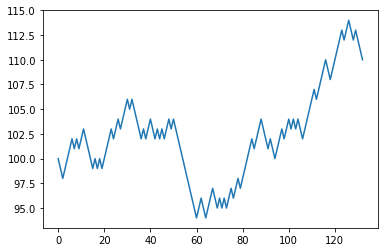

In [63]:
new_strategy(2012)

[100, 99, 100, 101, 102, 101, 100, 101, 100, 99, 100, 101, 102, 103, 104, 103, 104, 105, 104, 105, 106, 107, 106, 105, 106, 105, 104, 105, 106, 107, 108, 109, 108, 107, 106, 107, 108, 109, 110, 109, 110, 111, 110, 111, 110, 111, 110, 111, 110, 111, 112, 113, 114, 115, 114, 113, 112, 113, 112, 113, 112, 113, 114, 113, 112, 113, 114, 113, 112, 111, 110, 111, 112, 111]


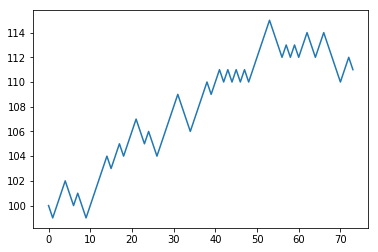

In [64]:
new_strategy(2011)

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

[100, 99, 100, 101, 102, 101, 102, 101, 102, 101, 100, 101, 102, 101, 100, 101, 102, 101, 102, 103, 104, 105, 104, 105, 106, 105, 104, 105, 106, 105, 106, 105, 104, 103, 104, 105, 106, 105, 106, 105, 106, 107, 106, 105, 104, 103, 104, 103, 104, 105, 106, 107, 108, 109, 110, 109, 110, 111, 110, 111, 112, 111, 112, 113, 114, 115, 114, 113, 114, 115, 114, 113, 114, 113, 112, 113, 114, 115, 116, 115, 116, 117, 116, 117, 116, 115, 116, 115, 114, 115, 116, 117, 116, 117, 118, 119]


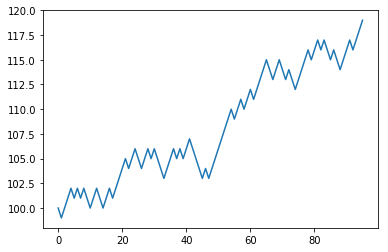

In [65]:
new_strategy(2010)

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

[100, 99, 100, 101, 102, 103, 104, 105, 104, 105, 106, 107, 106, 107, 108, 107, 108, 107, 106, 107, 106, 105, 104, 103, 104, 105, 104, 103, 104, 105, 106, 105, 104, 105, 104, 105, 104, 105, 104, 103, 104, 103, 102, 101, 102, 101, 100, 99, 98, 97, 98, 99, 98, 99, 100, 101, 100, 101, 100, 101, 102, 101, 102, 103, 104, 105, 104, 103, 102, 103, 104, 103, 104, 105, 106, 105, 104, 103, 104, 103, 104, 103, 102, 101, 102, 103, 102, 103, 102, 103, 104, 105, 106, 107, 106, 105, 106, 105, 106, 107, 108, 109, 108, 109, 108, 107, 106, 105, 106, 105, 106]


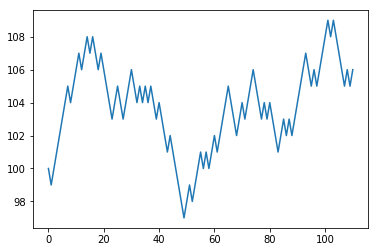

In [66]:
new_strategy(2009)

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

[100, 101, 100, 99, 100, 99, 100, 99, 100, 99, 100, 99, 100, 101, 100, 99, 98, 99, 98, 99, 100, 99, 100, 99, 100, 101, 102, 103, 104, 103, 102, 103, 104, 103, 102, 101, 100, 99, 98, 97, 98, 99, 98, 99, 100, 101, 100, 99, 100, 101, 100, 101, 102, 103, 104, 105, 104, 103, 104, 105, 106, 105, 104, 105, 106, 107, 108, 107, 106, 105, 106, 105, 104, 103, 104, 103, 104, 105, 106, 105, 106, 105, 104, 103, 104, 105, 106, 105, 106, 107, 106, 107, 106, 107, 108, 107, 106, 107, 106, 105, 104, 103, 104, 105, 106, 107, 108, 107, 108, 107]


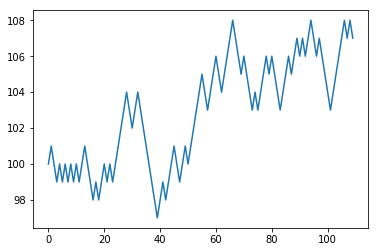

In [67]:
new_strategy(2008)

In [77]:
# new strategy - generate average per game id and then bet on that game
def new_strategy_tune_params(year):
    games = pd.read_csv("nba_games_all.csv")
    games = games.sort_values(by="game_id")
    games = games.sort_values(by="game_date")
    games = games[games["season_year"]==year]
    games = games[games["season_type"]=="Regular Season"]

    spread_odds = pd.read_csv("nba_betting_spread.csv")
    spread_odds = spread_odds[spread_odds["book_name"]=="Pinnacle Sports"]

    game_ids = sorted(list(set(games["game_id"])))

    probability_dict = {}
    over_list = []
    under_list = []
    for game_id in game_ids[750:]:

        # find total number of games played by each team by adding record
        desired_game = games[games["game_id"]==game_id]

        #print(desired_game) #47 is LAL

        home_game = desired_game.loc[desired_game['matchup'].str.contains("@")]
        away_game = desired_game = desired_game.loc[desired_game['matchup'].str.contains("vs")]
        home_team_games_played = int(home_game['w'] + home_game['l'])
        away_team_games_played = int(away_game['w'] + away_game['l'])
        #print(home_team_games_played)
        #print(away_team_games_played)

        # then find moving average and variance number of points scored by each team
        home_team_id = int(np.mean(home_game['team_id']))
        away_team_id = int(np.mean(away_game['team_id']))
        #print(home_team_id)
        #print(away_team_id)

        home_team_df = games[games["team_id"]==home_team_id].sort_values(by="game_id")
        away_team_df = games[games["team_id"]==away_team_id].sort_values(by="game_id")

        home_points = home_team_df['pts'][home_team_games_played-30:home_team_games_played]
        away_points = away_team_df['pts'][away_team_games_played-30:away_team_games_played]

        home_points_mean = np.mean(home_points)
        away_points_mean = np.mean(away_points)
        home_points_std = np.std(home_points)
        away_points_std = np.std(away_points)

        # then find moving average of number of points allowed by each team
        home_team_points_allowed_df = games[games["a_team_id"]==home_team_id].sort_values(by="game_id")
        home_team_mean_points_allowed = np.mean(home_team_points_allowed_df['pts'][home_team_games_played-30:home_team_games_played])

        away_team_points_allowed_df = games[games["a_team_id"]==away_team_id].sort_values(by="game_id")
        away_team_mean_points_allowed = np.mean(away_team_points_allowed_df['pts'][away_team_games_played-30:away_team_games_played])

        # pull the spread for that game
        spread = float(np.mean(spread_odds[spread_odds["game_id"] == game_id]["spread1"])) # amount home team should win by
        #print(spread)

        # calculate p value for that spread based on expected number of points scored and variance
        home_points_scored = np.mean([home_points_mean, away_team_mean_points_allowed])
        away_points_scored = np.mean([away_points_mean, home_team_mean_points_allowed])
        expected_spread = home_points_scored - away_points_scored
        spread_std = np.sqrt(home_points_std**2 + away_points_std**2)

        probability = scipy.stats.norm(expected_spread, spread_std).cdf(spread)
        if probability > 0.65:
            under_list.append(game_id)
        elif probability < 0.35:
            over_list.append(game_id)

        #probability_dict[game_id]=scipy.stats.norm(expected_spread, spread_std).cdf(spread)
        #print(expected_spread)
    portfolio = []
    portfolio.append(100)
    for game_id in game_ids:
        if game_id in over_list:
            spread = float(spread_odds[spread_odds["game_id"]==game_id]["spread1"])
            outcomes = games[games["game_id"]==game_id]
            #outcomes = outcomes.loc[outcomes['matchup'].str.contains("@")]
            home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
            away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
            if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                continue
            actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))

            if actual_spread > spread:
                portfolio.append(portfolio[len(portfolio)-1]+1)
            else:
                portfolio.append(portfolio[len(portfolio)-1]-1)

        if game_id in under_list:
            spread = float(spread_odds[spread_odds["game_id"]==game_id]["spread1"])
            outcomes = games[games["game_id"]==game_id]
            #outcomes = outcomes.loc[outcomes['matchup'].str.contains("@")]

            home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
            away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
            if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                continue
            actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))
            if actual_spread < spread:
                portfolio.append(portfolio[len(portfolio)-1]+1)
            else:
                portfolio.append(portfolio[len(portfolio)-1]-1)
    print(portfolio)
    plt.plot(range(len(portfolio)),portfolio)




[100, 101, 100, 101, 100, 101, 102, 101, 102, 101, 102, 103, 104, 103, 102, 103, 104, 105, 106, 107, 106, 107, 108, 107, 106, 107, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 114, 115, 114, 113, 114, 115, 116, 117, 116, 115, 114, 115, 116, 117, 116, 117, 116, 117, 118, 119, 120, 119, 120, 121, 120, 119, 120, 121, 120, 119, 118, 117, 116, 115, 116, 117, 118, 117, 118, 119, 118, 119, 120, 119, 120, 121, 120, 119, 120, 119, 120, 119, 120, 121, 122, 121, 120, 121, 120, 119, 120, 121, 120, 121, 122, 123, 124, 125, 126, 125, 126, 127, 126, 127, 128, 127, 126, 127, 128, 127, 128, 129, 128, 129, 128, 129, 128, 127, 128, 127, 128, 129, 128, 127]


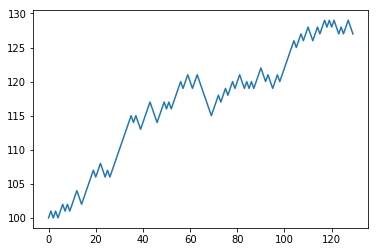

In [78]:
new_strategy_tune_params(2016)

[100, 101, 102, 101, 102, 101, 100, 101, 100, 99, 100, 101, 102, 101, 100, 101, 100, 99, 100, 101, 100, 99, 100, 99, 100, 101, 102, 103, 102, 101, 100, 99, 100, 101, 102, 101, 102, 101, 102, 101, 102, 101, 102, 101, 102, 101, 100, 101, 100, 101, 102, 101, 102, 101, 102, 101, 102, 101, 100, 101, 100, 101, 102, 103, 102, 103, 104, 105, 104, 105, 104, 105, 104, 103, 102, 103, 104, 103, 104, 103, 102, 101, 102, 103, 102, 101, 102, 101, 102, 103, 104, 103, 102, 103, 102, 101, 102, 101, 100, 101, 102, 101]


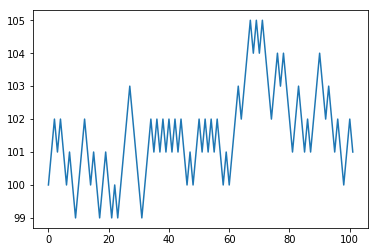

In [79]:
new_strategy_tune_params(2017)

[100, 99, 98, 97, 96, 97, 98, 99, 98, 99, 100, 99, 98, 99, 100, 99, 100, 101, 100, 99, 100, 99, 98, 99, 100, 101, 102, 103, 104, 103, 102, 103, 102, 103, 104, 103, 104, 103, 102, 103, 104, 105, 104, 103, 102, 101, 100, 101, 100, 99, 100, 99, 100, 101, 102, 101, 102, 103, 102, 103, 102, 103, 102, 101, 102, 103, 102, 103, 104, 103, 102, 103, 102, 103, 104, 103, 104, 105, 106, 105, 104, 105, 104, 105, 104, 105, 104, 105, 106, 105, 106, 107, 106, 107, 108, 107, 106, 107, 106, 105, 106, 107, 106, 105, 104, 105, 106, 107, 106, 105, 104, 103, 104, 103, 104, 105, 104, 103, 102, 101, 102, 101, 102, 101, 102, 101, 102, 101, 102, 101, 102, 101, 100, 99, 100]


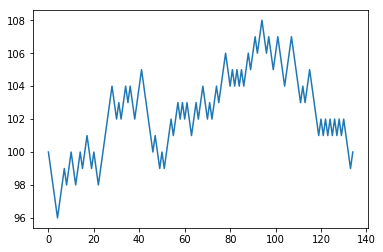

In [80]:
new_strategy_tune_params(2015)

In [112]:
# new strategy - generate average per game id and then bet on that game
def new_strategy_running_portfolio(years, portfolio):
    for year in years:
        games = pd.read_csv("nba_games_all.csv")
        games = games.sort_values(by="game_id")
        games = games.sort_values(by="game_date")
        games = games[games["season_year"]==year]
        games = games[games["season_type"]=="Regular Season"]

        spread_odds = pd.read_csv("nba_betting_spread.csv")
        spread_odds = spread_odds[spread_odds["book_name"]=="Pinnacle Sports"]

        game_ids = sorted(list(set(games["game_id"])))

        probability_dict = {}
        over_list = []
        under_list = []
        for game_id in game_ids[750:]:

            # find total number of games played by each team by adding record
            desired_game = games[games["game_id"]==game_id]

            #print(desired_game) #47 is LAL

            home_game = desired_game.loc[desired_game['matchup'].str.contains("@")]
            away_game = desired_game = desired_game.loc[desired_game['matchup'].str.contains("vs")]
            home_team_games_played = int(home_game['w'] + home_game['l'])
            away_team_games_played = int(away_game['w'] + away_game['l'])
            #print(home_team_games_played)
            #print(away_team_games_played)

            # then find moving average and variance number of points scored by each team
            home_team_id = int(np.mean(home_game['team_id']))
            away_team_id = int(np.mean(away_game['team_id']))
            #print(home_team_id)
            #print(away_team_id)

            home_team_df = games[games["team_id"]==home_team_id].sort_values(by="game_id")
            away_team_df = games[games["team_id"]==away_team_id].sort_values(by="game_id")

            home_points = home_team_df['pts'][:home_team_games_played]
            away_points = away_team_df['pts'][:away_team_games_played]

            home_points_mean = np.mean(home_points)
            away_points_mean = np.mean(away_points)
            home_points_std = np.std(home_points)
            away_points_std = np.std(away_points)

            # then find moving average of number of points allowed by each team
            home_team_points_allowed_df = games[games["a_team_id"]==home_team_id].sort_values(by="game_id")
            home_team_mean_points_allowed = np.mean(home_team_points_allowed_df['pts'][:home_team_games_played])

            away_team_points_allowed_df = games[games["a_team_id"]==away_team_id].sort_values(by="game_id")
            away_team_mean_points_allowed = np.mean(away_team_points_allowed_df['pts'][:away_team_games_played])

            # pull the spread for that game
            spread = float(np.mean(spread_odds[spread_odds["game_id"] == game_id]["spread1"])) # amount home team should win by
            #print(spread)

            # calculate p value for that spread based on expected number of points scored and variance
            home_points_scored = np.mean([home_points_mean, away_team_mean_points_allowed])
            away_points_scored = np.mean([away_points_mean, home_team_mean_points_allowed])
            expected_spread = home_points_scored - away_points_scored
            spread_std = np.sqrt(home_points_std**2 + away_points_std**2)

            probability = scipy.stats.norm(expected_spread, spread_std).cdf(spread)
            if probability > 0.65:
                under_list.append(game_id)
            elif probability < 0.35:
                over_list.append(game_id)

            #probability_dict[game_id]=scipy.stats.norm(expected_spread, spread_std).cdf(spread)
            #print(expected_spread)
        
        for game_id in game_ids:
            if game_id in over_list:
                spread = float(spread_odds[spread_odds["game_id"]==game_id]["spread1"])
                outcomes = games[games["game_id"]==game_id]
                home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
                away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
                if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                    continue
                actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))

                if actual_spread > spread:
                    portfolio.append(portfolio[len(portfolio)-1]+1)
                else:
                    portfolio.append(portfolio[len(portfolio)-1]-1)

            if game_id in under_list:
                spread = float(spread_odds[spread_odds["game_id"]==game_id]["spread1"])
                outcomes = games[games["game_id"]==game_id]
                #outcomes = outcomes.loc[outcomes['matchup'].str.contains("@")]

                home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
                away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
                if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                    continue
                actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))
                if actual_spread < spread:
                    portfolio.append(portfolio[len(portfolio)-1]+1)
                else:
                    portfolio.append(portfolio[len(portfolio)-1]-1.1)
    print(portfolio)
    plt.plot(range(len(portfolio)),portfolio)




c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

[100, 98.9, 97.80000000000001, 98.80000000000001, 99.80000000000001, 100.80000000000001, 101.80000000000001, 100.70000000000002, 101.70000000000002, 100.60000000000002, 101.60000000000002, 102.60000000000002, 101.50000000000003, 100.40000000000003, 99.30000000000004, 98.20000000000005, 99.20000000000005, 98.10000000000005, 99.10000000000005, 98.00000000000006, 99.00000000000006, 100.00000000000006, 101.00000000000006, 102.00000000000006, 100.90000000000006, 101.90000000000006, 102.90000000000006, 101.80000000000007, 102.80000000000007, 103.80000000000007, 104.80000000000007, 103.70000000000007, 104.70000000000007, 103.60000000000008, 102.50000000000009, 101.40000000000009, 100.3000000000001, 101.3000000000001, 100.2000000000001, 101.2000000000001, 102.2000000000001, 101.10000000000011, 100.00000000000011, 101.00000000000011, 99.90000000000012, 100.90000000000012, 99.80000000000013, 100.80000000000013, 101.80000000000013, 100.70000000000013, 101.70000000000013, 100.60000000000014, 99.50

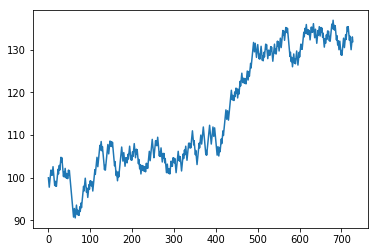

In [113]:
new_strategy_running_portfolio([2012, 2013, 2014, 2015, 2016, 2017], [100])

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

[100, 101, 99.9, 98.80000000000001, 99.80000000000001, 98.70000000000002, 99.70000000000002, 98.60000000000002, 99.60000000000002, 98.50000000000003, 99.50000000000003, 98.40000000000003, 99.40000000000003, 100.40000000000003, 99.30000000000004, 98.20000000000005, 97.10000000000005, 98.10000000000005, 97.00000000000006, 98.00000000000006, 99.00000000000006, 97.90000000000006, 98.90000000000006, 97.80000000000007, 98.80000000000007, 99.80000000000007, 100.80000000000007, 101.80000000000007, 102.80000000000007, 101.70000000000007, 100.60000000000008, 101.60000000000008, 102.60000000000008, 101.50000000000009, 100.40000000000009, 99.3000000000001, 98.2000000000001, 97.10000000000011, 96.00000000000011, 94.90000000000012, 95.90000000000012, 96.90000000000012, 95.80000000000013, 96.80000000000013, 97.80000000000013, 98.80000000000013, 97.70000000000013, 96.60000000000014, 97.60000000000014, 98.60000000000014, 97.50000000000014, 98.50000000000014, 99.50000000000014, 100.50000000000014, 101.5

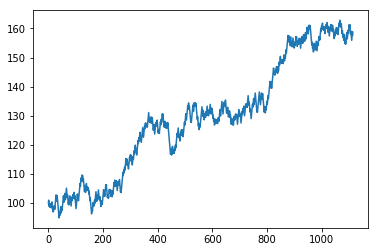

In [114]:
new_strategy_running_portfolio([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], [100])

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


[100, 101, 100, 99, 100, 99, 100, 99, 100, 99, 100, 99, 100, 101, 100, 99, 98, 99, 98, 99, 100, 99, 100, 99, 100, 101, 102, 103, 104, 103, 102, 103, 104, 103, 102, 101, 100, 99, 98, 97, 98, 99, 98, 99, 100, 101, 100, 99, 100, 101, 100, 101, 102, 103, 104, 105, 104, 103, 104, 105, 106, 105, 104, 105, 106, 107, 108, 107, 106, 105, 106, 105, 104, 103, 104, 103, 104, 105, 106, 105, 106, 105, 104, 103, 104, 105, 106, 105, 106, 107, 106, 107, 106, 107, 108, 107, 106, 107, 106, 105, 104, 103, 104, 105, 106, 107, 108, 107, 108, 107, 106, 107, 108, 109, 110, 111, 112, 111, 112, 113, 114, 113, 114, 115, 114, 115, 114, 113, 114, 113, 112, 111, 110, 111, 112, 111, 110, 111, 112, 113, 112, 111, 112, 111, 112, 111, 112, 111, 110, 111, 110, 109, 108, 109, 108, 107, 106, 105, 104, 105, 106, 105, 106, 107, 108, 107, 108, 107, 108, 109, 108, 109, 110, 111, 112, 111, 110, 109, 110, 111, 110, 111, 112, 113, 112, 111, 110, 111, 110, 111, 110, 109, 108, 109, 110, 109, 110, 109, 110, 111, 112, 113, 114, 113,

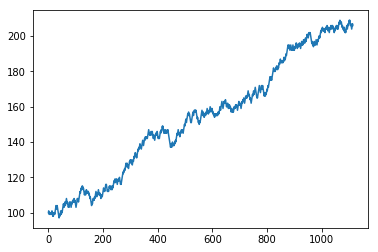

In [109]:
new_strategy_running_portfolio([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], [100])

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

[100, 99, 98, 97, 98, 99, 100, 101, 100, 101, 102, 101, 100, 99, 98, 99, 100, 99, 98, 99, 98, 99, 98, 97, 98, 97, 98, 99, 100, 99, 100, 101, 100, 101, 102, 103, 102, 103, 102, 101, 100, 99, 98, 99, 100, 99, 100, 101, 100, 99, 100, 101, 102, 101, 102, 101, 100, 99, 98, 97, 96, 95, 96, 95, 94, 95, 96, 97, 96, 95, 94, 95, 94, 95, 94, 93, 94, 93, 94, 93, 94, 95, 96, 95, 96, 97, 98, 97, 98, 97, 98, 97, 98, 99, 98, 99, 100, 101, 100, 99, 100, 101, 102, 101, 102, 101, 102, 103, 102, 101, 100, 101, 102, 103, 104, 105, 104, 105, 106, 107, 106, 107, 108, 109, 110, 111, 112, 111, 112, 111, 112, 113, 112, 111, 110, 111, 110, 109, 108, 107, 106, 107, 108, 107, 106, 107, 108, 109, 108, 109, 110, 109, 110, 109, 108, 107, 108, 109, 110, 109, 110, 109, 108, 109, 108, 109, 108, 107, 108, 109, 108, 107, 106, 107, 106, 105, 104, 105, 106, 107, 106, 107, 108, 107, 106, 107, 108, 109, 108, 109, 108, 107, 108, 107, 106, 107, 108, 107, 106, 105, 106, 107, 106, 105, 106, 105, 106, 105, 106, 107, 108, 107, 106,

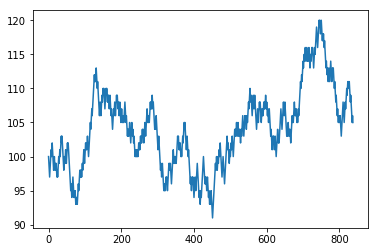

In [111]:
new_strategy_test_portfolio([2012, 2013, 2014, 2015, 2016, 2017], [100])

In [128]:
# new strategy - generate average per game id and then bet on that game
def new_strategy_running_portfolio(years, portfolio):
    predicted_spreads = []
    actual_spreads = []
    betting_dict = {}
    actual_dict = {}
    for year in years:
        games = pd.read_csv("nba_games_all.csv")
        games = games.sort_values(by="game_id")
        games = games.sort_values(by="game_date")
        games = games[games["season_year"]==year]
        games = games[games["season_type"]=="Regular Season"]

        spread_odds = pd.read_csv("nba_betting_spread.csv")
        spread_odds = spread_odds[spread_odds["book_name"]=="Pinnacle Sports"]

        game_ids = sorted(list(set(games["game_id"])))

        probability_dict = {}
        over_list = []
        under_list = []
        for game_id in game_ids[750:]:

            # find total number of games played by each team by adding record
            desired_game = games[games["game_id"]==game_id]

            #print(desired_game) #47 is LAL

            home_game = desired_game.loc[desired_game['matchup'].str.contains("@")]
            away_game = desired_game = desired_game.loc[desired_game['matchup'].str.contains("vs")]
            home_team_games_played = int(home_game['w'] + home_game['l'])
            away_team_games_played = int(away_game['w'] + away_game['l'])
            #print(home_team_games_played)
            #print(away_team_games_played)

            # then find moving average and variance number of points scored by each team
            home_team_id = int(np.mean(home_game['team_id']))
            away_team_id = int(np.mean(away_game['team_id']))
            #print(home_team_id)
            #print(away_team_id)

            home_team_df = games[games["team_id"]==home_team_id].sort_values(by="game_id")
            away_team_df = games[games["team_id"]==away_team_id].sort_values(by="game_id")

            home_points = home_team_df['pts'][:home_team_games_played]
            away_points = away_team_df['pts'][:away_team_games_played]

            home_points_mean = np.mean(home_points)
            away_points_mean = np.mean(away_points)
            home_points_std = np.std(home_points)
            away_points_std = np.std(away_points)

            # then find moving average of number of points allowed by each team
            home_team_points_allowed_df = games[games["a_team_id"]==home_team_id].sort_values(by="game_id")
            home_team_mean_points_allowed = np.mean(home_team_points_allowed_df['pts'][:home_team_games_played])

            away_team_points_allowed_df = games[games["a_team_id"]==away_team_id].sort_values(by="game_id")
            away_team_mean_points_allowed = np.mean(away_team_points_allowed_df['pts'][:away_team_games_played])

            # pull the spread for that game
            spread = float(np.mean(spread_odds[spread_odds["game_id"] == game_id]["spread1"])) # amount home team should win by
            #print(spread)

            # calculate p value for that spread based on expected number of points scored and variance
            home_points_scored = np.mean([home_points_mean, away_team_mean_points_allowed])
            away_points_scored = np.mean([away_points_mean, home_team_mean_points_allowed])
            expected_spread = home_points_scored - away_points_scored
            spread_std = np.sqrt(home_points_std**2 + away_points_std**2)

            probability = scipy.stats.norm(expected_spread, spread_std).cdf(spread)
            if probability > 0.65:
                under_list.append(game_id)
                betting_dict[game_id] = expected_spread
            elif probability < 0.35:
                over_list.append(game_id)
                betting_dict[game_id] = expected_spread

            #probability_dict[game_id]=scipy.stats.norm(expected_spread, spread_std).cdf(spread)
            #print(expected_spread)
        
        for game_id in game_ids:
            if game_id in over_list:
                spread = float(spread_odds[spread_odds["game_id"]==game_id]["spread1"])
                outcomes = games[games["game_id"]==game_id]
                home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
                away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
                if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                    continue
                actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))
                actual_dict[game_id] = actual_spread
                if actual_spread > spread:
                    portfolio.append(portfolio[len(portfolio)-1]+1)
                else:
                    portfolio.append(portfolio[len(portfolio)-1]-1)

            if game_id in under_list:
                spread = float(spread_odds[spread_odds["game_id"]==game_id]["spread1"])
                outcomes = games[games["game_id"]==game_id]
                #outcomes = outcomes.loc[outcomes['matchup'].str.contains("@")]

                home_team = outcomes.loc[outcomes['matchup'].str.contains("@")]
                away_team = outcomes.loc[outcomes['matchup'].str.contains("vs")]
                if np.isnan(np.mean(home_team["pts"])) or np.isnan(np.mean(away_team["pts"])):
                    continue
                actual_spread = int(np.mean(home_team["pts"])) - int(np.mean(away_team["pts"]))
                actual_dict[game_id] = actual_spread
                if actual_spread < spread:
                    portfolio.append(portfolio[len(portfolio)-1]+1)
                else:
                    portfolio.append(portfolio[len(portfolio)-1]-1.1)
    print(portfolio)
    plt.plot(range(len(portfolio)),portfolio)
    return betting_dict, actual_dict

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & 

c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


[100, 101, 99.9, 98.80000000000001, 99.80000000000001, 98.70000000000002, 99.70000000000002, 98.60000000000002, 99.60000000000002, 98.50000000000003, 99.50000000000003, 98.40000000000003, 99.40000000000003, 100.40000000000003, 99.30000000000004, 98.20000000000005, 97.10000000000005, 98.10000000000005, 97.00000000000006, 98.00000000000006, 99.00000000000006, 97.90000000000006, 98.90000000000006, 97.80000000000007, 98.80000000000007, 99.80000000000007, 100.80000000000007, 101.80000000000007, 102.80000000000007, 101.70000000000007, 100.60000000000008, 101.60000000000008, 102.60000000000008, 101.50000000000009, 100.40000000000009, 99.3000000000001, 98.2000000000001, 97.10000000000011, 96.00000000000011, 94.90000000000012, 95.90000000000012, 96.90000000000012, 95.80000000000013, 96.80000000000013, 97.80000000000013, 98.80000000000013, 97.70000000000013, 96.60000000000014, 97.60000000000014, 98.60000000000014, 97.50000000000014, 98.50000000000014, 99.50000000000014, 100.50000000000014, 101.5

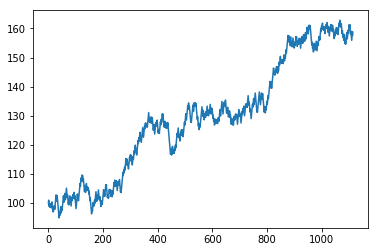

In [129]:
betting_dict, actual_dict = new_strategy_running_portfolio([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], [100])


LinregressResult(slope=1.5571743824047222, intercept=5.250371832170831, rvalue=0.40052076440384676, pvalue=3.577367201331952e-44, stderr=0.10682961638985543)

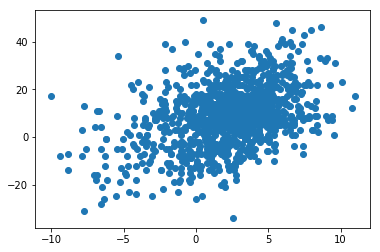

In [133]:
betting_list = []
actual_list = []
for key in betting_dict:
    betting_list.append(betting_dict[key])
    actual_list.append(actual_dict[key])
plt.scatter(betting_list, actual_list)
scipy.stats.linregress(betting_list, actual_list)

In [123]:
scipy.stats.linregress(list(predicted_spreads), list(actual_spreads))


LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)